# Combining MQTT and STMPY

In this notebook, we want to combine MQTT with a STMPY state machine. For just getting this first connection implemented, the result does nothing really useful, but should be easy to run and debug. I promise, the system we are going to build next week based on what we learn this week will be more useful, but this way we can learn one thing at a time.

The application is simple:

 * We subscribe to an MQTT topic.
 * Whenever we receive a message at that topic, we trigger an event `message` in the state machine.
 * The state machine just switches between to states `tick` and `tock`.
 * Whenver the state machine switches, it also publishes an MQTT message that show the number of ticks and tocks.
 
Here is the diagram of the machine:

![](images/mqtt-tick-tock.png)

Let us first declare this machine, in the same way we did it before in STMPY:

In [8]:
from stmpy import Machine, Driver

class Tick:

    def on_init(self):
        print('Init!')
        self.ticks = 0
        self.tocks = 0

    def send_mqtt_tick(self):
        print('Tick! {}'.format(self.ticks))
        self.ticks = self.ticks + 1
        self.mqtt_client.publish('tick', self.ticks)

    def send_mqtt_tock(self):
        print('Tock! {}'.format(self.tocks))
        self.tocks = self.tocks + 1
        self.mqtt_client.publish('tock', self.ticks)

# initial transition
t0 = {'source': 'initial', 
      'target': 's_tick',
      'effect': 'on_init'}

t1 = {'trigger':'message', 
      'source':'s_tick', 
      'target':'s_tock', 
      'effect':'send_mqtt_tick'}

t2 = {'trigger':'message', 
      'source':'s_tock', 
      'target':'s_tick', 
      'effect':'send_mqtt_tock'}

The coupling with MQTT is only visible at a few points:

 * We use the line `self.mqtt_client.publish('tick', self.ticks)` to publish the MQTT message. We just need to remember to set the variable `self.mqtt_client` with the Paho MQTT client. (Note that we here use the Paho client direclty, not our wrapper class MQTT_Client_1).
 * The state machine is triggered by the message `message`. This will be dispatched by the MQTT client.

In [11]:
import paho.mqtt.client as mqtt
from threading import Thread

class MQTT_Client_1:
    
    def __init__(self):
        self.count = 0
        self.client = mqtt.Client()
        self.client.on_connect = self.on_connect
        self.client.on_message = self.on_message
        
    def on_connect(self, client, userdata, flags, rc):
        print('on_connect(): {}'.format(mqtt.connack_string(rc)))
        
    def on_message(self, client, userdata, msg):
        print('on_message(): topic: {}'.format(msg.topic))
        self.stm_driver.send('message', 'tick_tock')
        
    def start(self, broker, port):

        print('Connecting to {}:{}'.format(broker, port))
        self.client.connect(broker, port)

        self.client.subscribe("ttm4115")
        
        try:
            thread = Thread(target=self.client.loop_forever())
            thread.start()
        except KeyboardInterrupt:
            print('Interrupted')
            self.client.disconnect()

Our MQTT client above is now configured so that whenever it receives an MQTT message, it dispatches a message into the state machine driver, with the `tick_tock` machine as address, so that it is sent to the state machine. There, it triggers the transitions.

In the following, we start the MQTT client and the state machine driver, connect them with each other, and start everything:

In [ ]:
broker, port = 'iot.eclipse.org', 1883
broker, port = 'localhost', 1883

tick = Tick()
tick_tock_machine = Machine(transitions=[t0, t1, t2], obj=tick, name='tick_tock')
tick.stm = tick_tock_machine

driver = Driver()
driver.add_machine(tick_tock_machine)

myclient = MQTT_Client_1()
tick.mqtt_client = myclient.client
myclient.stm_driver = driver

driver.start()
myclient.start(broker, port)

Init!
Connecting to localhost:1883
on_connect(): Connection Accepted.
on_message(): topic: ttm4115
Tick! 0


Error when running function send_mqtt_tock from machine.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/site-packages/stmpy/__init__.py", line 590, in _run_function
    func(*args, **kwargs)
  File "<ipython-input-8-15d3ab2cce48>", line 18, in send_mqtt_tock
    self.client.publish('tock', self.ticks)
AttributeError: 'Tick' object has no attribute 'client'


on_message(): topic: ttm4115
Tock! 0
on_message(): topic: ttm4115
Tick! 1


.......
{'name': 'on_init', 'args': [], 'event_args': False}
.......
{'name': 'send_mqtt_tick', 'args': [], 'event_args': False}
.......
{'name': 'send_mqtt_tock', 'args': [], 'event_args': False}


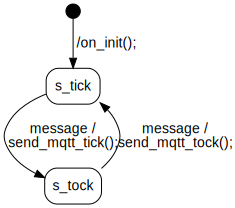

In [7]:
from graphviz import Source
import stmpy
dot = stmpy.get_graphviz_dot(tick_tock_machine)
src = Source(dot)
src